In [1]:

from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit import Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map
import pickle

In [2]:
# Save IBM account
#IBMQ.save_account('')
IBMQ.load_account()
# Choose the provider (if you have more than one)
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uminho-1', project='main')

# Show the possible backends
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-research-2', gr

In [3]:


# List queue times
for backend in provider.backends():
    if backend.configuration().simulator:
        continue
    try:
        qtime = backend.status().pending_jobs
    except:
        qtime = 'None'
    print(backend.name(), "has a queue time of", qtime)

ibmq_armonk has a queue time of None
ibmq_santiago has a queue time of None
ibmq_bogota has a queue time of None
ibmq_lima has a queue time of 67
ibmq_belem has a queue time of 39
ibmq_quito has a queue time of 39
ibmq_jakarta has a queue time of 41
ibmq_manila has a queue time of 40
ibm_lagos has a queue time of 39
ibm_nairobi has a queue time of 112
ibm_perth has a queue time of 11
ibm_oslo has a queue time of 51


# Quantum Chemistry
## Finding the minimum energy of moleculas
### Class of Quantum Computation of University of Minho
### 2022/2023
#### Maria Gabriela Jordão Oliveira, pg50599
#### Miguel Caçador Peixoto, pg

In [4]:
# Choose the "perfect" simulator
simulation_backend = Aer.get_backend("statevector_simulator")

# Choose the real device
real_device = provider.get_backend('ibm_perth')

# Create a simulator from the real device
sim_device = AerSimulator.from_backend(real_device)

/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (186064.81242819485 > 2 * 55387.74775816904). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (186064.81242819485 > 2 * 55387.74775816904). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoreti

In [5]:
# Exact solver for comparison
def exact_solver(problem, converter):
    '''
    This function finds the exact solution for a given problem and converter.
    This is a pure classical solver.
    '''
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

## H2
##### Expected energy: -1.117506  hartree
##### Expected bond length: 0.712 Angstrom

In [6]:
def get_qubit_op_h2(dist):
    '''
    Args:
    dist : Distance between H and H in Angstrom
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [ ]:
#backend = Aer.get_backend("statevector_simulator")
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_h2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=simulation_backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

# Save the data
with open("simulation_h2.pkl", "wb") as f:
    pickle.dump(vqe_energies, f)
with open("exact_h2.pkl", "wb") as f:
    pickle.dump(exact_energies, f)

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
var_form.num_qubits

In [ ]:
qubit_op.num_qubits

#### Simulador lagos

In [7]:
distances = np.arange(0.1, 1.1, 0.2)
exact_energies = []
vqe_energies = []


#Get noise model

coupling_map = sim_device.configuration().coupling_map
qi = QuantumInstance(sim_device,
                    coupling_map=coupling_map,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_h2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=20)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

# Save the data
with open("noise_simulation_h2.pkl", "wb") as f:
    pickle.dump(vqe_energies, f)

Interatomic Distance: 0.1 VQE Result: 3.39234 Exact Energy: 2.70996
Interatomic Distance: 0.3 VQE Result: -0.50931 Exact Energy: -0.60180
Interatomic Distance: 0.5 VQE Result: -0.78692 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -0.93921 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -0.71261 Exact Energy: -1.12056
All energies have been calculated


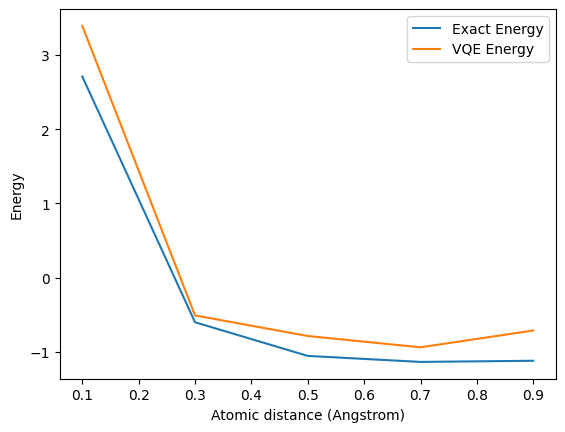

In [8]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [9]:
qubit_op.num_qubits

2